In [ ]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Files already downloaded and verified
Using device: cuda


Training epoch 1: 100%|██████████| 313/313 [03:11<00:00,  1.64it/s]


Epoch 1/8, Train Loss: 0.46753644091062274, Train Accuracy: 84.17%


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Validation Loss: 0.42833141284652904, Validation Accuracy: 86.67%


Training epoch 2: 100%|██████████| 313/313 [03:12<00:00,  1.63it/s]


Epoch 2/8, Train Loss: 0.1926019292669936, Train Accuracy: 93.57%


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Validation Loss: 0.3100902290095257, Validation Accuracy: 89.55%


Training epoch 3: 100%|██████████| 313/313 [03:11<00:00,  1.63it/s]


Epoch 3/8, Train Loss: 0.107873447965414, Train Accuracy: 96.30%


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Validation Loss: 0.41916234395172025, Validation Accuracy: 88.54%


Training epoch 4: 100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 4/8, Train Loss: 0.07519904932471368, Train Accuracy: 97.35%


Validating: 100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Validation Loss: 0.30350874581291704, Validation Accuracy: 91.04%


Training epoch 5: 100%|██████████| 313/313 [03:10<00:00,  1.65it/s]


Epoch 5/8, Train Loss: 0.06151448588330334, Train Accuracy: 97.86%


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Validation Loss: 0.27778056443114824, Validation Accuracy: 92.34%


Training epoch 6: 100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 6/8, Train Loss: 0.03892818238205327, Train Accuracy: 98.70%


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Validation Loss: 0.24761837586477586, Validation Accuracy: 93.30%


Training epoch 7: 100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 7/8, Train Loss: 0.031518368249812634, Train Accuracy: 98.89%


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Validation Loss: 0.2989498452295231, Validation Accuracy: 92.04%


Training epoch 8: 100%|██████████| 313/313 [03:10<00:00,  1.65it/s]


Epoch 8/8, Train Loss: 0.02027232050798988, Train Accuracy: 99.32%


Validating: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


Validation Loss: 0.25567483682704123, Validation Accuracy: 93.35%


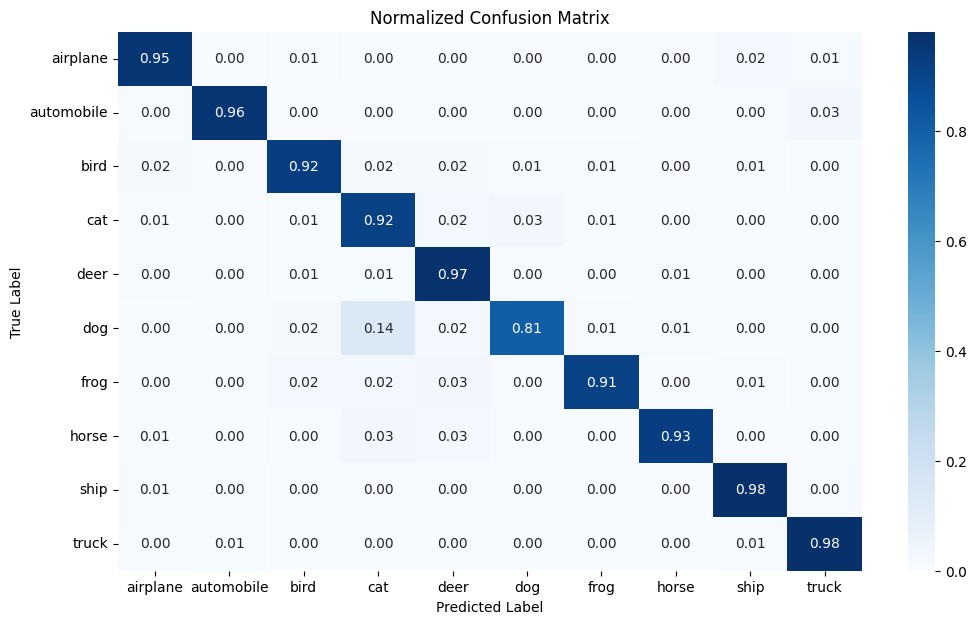

In [ ]:
# In the first model, we did not freeze any residual block layers, allowing all weights to be adjusted during training.


# Transformations for CIFAR-100
transform = transforms.Compose([
    # Resize to 224x224 for ResNet
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize using ImageNet's mean and std deviation
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load CIFAR-100 dataset
full_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
# tmp = int(0.25 * len(full_dataset))
# dataset = torch.utils.data.Subset(full_dataset, list(range(len(full_dataset)))[:tmp])

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
# val_size = len(full_dataset) - train_size  # 20% for validation
val_size = int(0.2 * len(full_dataset))
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
# The DataLoader in PyTorch splits the dataset into batches, each containing 64 samples.
# DataLoader automatically divides the data into inputs and outputs.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Load pre-trained ResNet model
resnet18 = models.resnet18(weights='IMAGENET1K_V1')

# Modify the final layer to match CIFAR-100
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, 10) # TODO: was 100 (better or worse?)
)

# Move the model to the GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'
# Print out the device being used
print(f'Using device: {device}')

resnet18 = resnet18.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet18.parameters(), lr=0.02) # lr = 0.001 -> 0.02
optimizer = optim.SGD(resnet18.parameters(), lr=0.02, momentum=0.9, weight_decay=5e-4)

# Function to train and validate the model
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, epochs, l1_reg = 0.0):
    train_accuracy = []
    validation_accuracy = []
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        epoch_loss = 0
        n_correct = 0
        n_examples = 0

        # Training part of the model
        for examples, labels in tqdm(train_loader, desc=f"Training epoch {epoch+1}"):
            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(examples.to(device))

            # Calculate loss
            loss = criterion(logits, labels.to(device))

            # Add regularization penalty to loss
            # l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
            # loss += l1_reg * l1_penalty

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Convert logits to predictions
            predicted_labels = torch.argmax(logits, dim=1)
            n_correct += (predicted_labels == labels.to(device)).sum().item()
            epoch_loss += loss.item()
            n_examples += labels.size(0)

        train_accuracy.append(n_correct / n_examples)
        train_loss.append(epoch_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss / len(train_loader)}, Train Accuracy: {train_accuracy[-1] * 100:.2f}%")

        # Validation part of the model
        # Set model to evaluation mode
        model.eval()
        validation_loss = 0
        n_correct = 0
        n_examples = 0

        # Disable gradients for validation
        with torch.no_grad():
            for examples, labels in tqdm(val_loader, desc="Validating"):

                # Forward pass
                logits = model(examples.to(device))

                # Calculate loss
                loss = criterion(logits, labels.to(device))

                # Convert logits to predictions
                predicted_labels = torch.argmax(logits, dim=1)
                n_correct += (predicted_labels == labels.to(device)).sum().item()
                validation_loss += loss.item()
                n_examples += labels.size(0)

        validation_accuracy.append(n_correct / n_examples)
        val_loss.append(validation_loss / len(val_loader))

        print(f"Validation Loss: {validation_loss / len(val_loader)}, Validation Accuracy: {validation_accuracy[-1] * 100:.2f}%")

# Call the training and validation function
train_and_validate_model(resnet18, train_loader, val_loader, criterion, optimizer, epochs=8)

y_pred = []
y_true = []
classes = full_dataset.classes
# classes = train_dataset.classes

for inputs, labels in val_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)

  output = resnet18(inputs)
  output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(output)

  labels = labels.data.cpu().numpy()
  y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix, axis=1, keepdims=True),
    index=classes,
    columns=classes
)

# Plot the confusion matrix
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.savefig('output.png')
plt.show()